In [1]:
import mysql.connector
import pandas as pd
from datetime import timedelta

# สร้างการเชื่อมต่อกับฐานข้อมูล
try:
    connection = mysql.connector.connect(
        host='localhost',
        user='root',      # แทนที่ด้วยชื่อผู้ใช้ MySQL ของคุณ
        password='Root',  # แทนที่ด้วยรหัสผ่าน MySQL ของคุณ
        database='smart_farm'
    )
    cursor = connection.cursor()
    print("เชื่อมต่อฐานข้อมูลสำเร็จ")
except mysql.connector.Error as err:
    print(f"เกิดข้อผิดพลาดในการเชื่อมต่อ: {err}")
    exit(1)

เชื่อมต่อฐานข้อมูลสำเร็จ


In [2]:
# อ่านข้อมูลจากไฟล์ CSV โดยใช้ pandas
df = pd.read_excel('data.xlsx')
# แปลงคอลัมน์ Timestamp เป็น datetime (pandas.Timestamp)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df.head()

,Timestamp,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,PH,Rainfall,Plant,Plant_season,...,Organic_matter,Irrigation_frequency (times/week),Crop_density,Pest_pressure,Fertilizer_usage,Growth_stage,Urban_area_proximity,Water_source_type,Frost_risk,Water_usage_efficiency
0,2025-01-01 08:00:00,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,September,...,3.121395,4,11.743910,57.607308,188.194958,Seedling,2.719614,Recycled,95.649985,1.193293
1,2025-01-01 09:00:00,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,September,...,2.142021,4,16.797101,74.736879,70.963629,Seedling,4.714427,Groundwater,77.265694,1.752672
2,2025-01-01 10:00:00,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,September,...,1.474974,1,12.654395,1.034478,191.976077,Seedling,30.431736,Groundwater,18.192168,3.035541
3,2025-01-01 11:00:00,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,June,...,8.393907,1,10.864360,24.091888,55.761388,Flowering,10.861071,Recycled,82.818720,1.273341
4,2025-01-01 12:00:00,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,March,...,5.202285,3,13.852910,38.811481,185.259702,Vegetative,47.190777,Recycled,25.466499,2.578671


In [ ]:
# วนลูปแต่ละแถวใน DataFrame
for index, row in df.iterrows():
    try:
        # ============================================================
        # 1. แทรกข้อมูลลงในตาราง Plant_Area
        # ============================================================
        plantation_area = row["Plantation_area"]
        soil_type = row["Soil_type"]
        
        query_pa = "SELECT PA_id FROM Plant_Area WHERE Plantation_area = %s AND Soil_type = %s"
        cursor.execute(query_pa, (plantation_area, soil_type))
        result = cursor.fetchone()
        if result:
            pa_id = result[0]
        else:
            insert_pa = "INSERT INTO Plant_Area (Plantation_area, Soil_type) VALUES (%s, %s)"
            cursor.execute(insert_pa, (plantation_area, soil_type))
            connection.commit()
            pa_id = cursor.lastrowid

        # ============================================================
        # 2. แทรกข้อมูลลงในตาราง Plant_Information
        # ============================================================
        plant = row["Plant"]
        urban_area_proximity = row["Urban_area_proximity"]
        insert_pi = "INSERT INTO Plant_Information (Plant, Urban_area_proximity, PA_id) VALUES (%s, %s, %s)"
        cursor.execute(insert_pi, (plant, urban_area_proximity, pa_id))
        connection.commit()
        plant_id = cursor.lastrowid

        # ============================================================
        # 3. แทรกข้อมูลลงในตาราง Sensor_Data
        # ============================================================
        # แปลง Timestamp เป็น Python datetime object
        original_dt = row["Timestamp"].to_pydatetime()
        nitrogen = row["Nitrogen"]
        phosphorus = row["Phosphorus"]
        potassium = row["Potassium"]
        temperature = row["Temperature"]
        humidity = row["Humidity"]
        ph_val = row["PH"]
        rainfall = row["Rainfall"]
        organic_matter = row["Organic_matter"]
        wind_speed = row["Wind_speed"]
        co2_concentration = row["CO2_concentration"]
        soil_moisture = row["Soil_moisture"]

        insert_sd = """
            INSERT INTO Sensor_Data 
            (TimestampPerHr, Temperature, humidity, ph, rainfall, nitrogen, phosphorus, potassium, organic_matter, Wind_speed, CO2_concentration, Soil_moisture, Plant_id)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """
        cursor.execute(insert_sd, (original_dt, temperature, humidity, ph_val, rainfall, nitrogen, phosphorus, potassium, organic_matter, wind_speed, co2_concentration, soil_moisture, plant_id))
        connection.commit()

        # ============================================================
        # 4. แทรกข้อมูลลงในตาราง Plant_Growth
        # ============================================================
        growth_stage = row["Growth_stage"]
        plant_season = row["Plant_season"]
        # แปลง Timestamp เป็นวันที่ 1 ของเดือน เวลา 00:00:00 (เดือนละครั้ง)
        dt_month = original_dt.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
        insert_pg = "INSERT INTO Plant_Growth (Growth_stage, Plant_season, Timestamp_Per_Month, Plant_id) VALUES (%s, %s, %s, %s)"
        cursor.execute(insert_pg, (growth_stage, plant_season, dt_month, plant_id))
        connection.commit()

        # ============================================================
        # 5. แทรกข้อมูลลงในตาราง Crop_Management
        # ============================================================
        crop_density = row["Crop_density"]
        fertilizer_usage = row["Fertilizer_usage"]
        pest_pressure = row["Pest_pressure"]
        sunlight_exposure = row["Sunlight_exposure"]
        # แปลง Timestamp เป็นวันนั้น เวลา 00:00:00 (วันละครั้ง)
        dt_day = original_dt.replace(hour=0, minute=0, second=0, microsecond=0)
        insert_cm = "INSERT INTO Crop_Management (Crop_density, Fertilizer_usage, Pest_pressure, Sunlight_exposure, TimestampPerDay, Plant_id) VALUES (%s, %s, %s, %s, %s, %s)"
        cursor.execute(insert_cm, (crop_density, fertilizer_usage, pest_pressure, sunlight_exposure, dt_day, plant_id))
        connection.commit()

        # ============================================================
        # 6. แทรกข้อมูลลงในตาราง Water_Management
        # ============================================================
        water_source_type = row["Water_source_type"]
        irrigation_frequency = row["Irrigation_frequency (times/week)"]
        water_usage_efficiency = row["Water_usage_efficiency"]
        frost_risk = row["Frost_risk"]
 
        days_to_sunday = 6 - dt_day.weekday()  
        dt_week = dt_day + timedelta(days=days_to_sunday)
        insert_wm = "INSERT INTO Water_Management (Water_source_type, Irrigation_frequency, Water_usage_efficiency, Frost_risk, TimestampPerWeek, Plant_id) VALUES (%s, %s, %s, %s, %s, %s)"
        cursor.execute(insert_wm, (water_source_type, irrigation_frequency, water_usage_efficiency, frost_risk, dt_week, plant_id))
        connection.commit()

        print(f"Record {index} inserted successfully!")

    except Exception as e:
        print(f"Error at record {index}: {e}")
        connection.rollback()

Record 0 inserted successfully!
Record 1 inserted successfully!
Record 2 inserted successfully!
Record 3 inserted successfully!
Record 4 inserted successfully!
Record 5 inserted successfully!
Record 6 inserted successfully!
Record 7 inserted successfully!
Record 8 inserted successfully!
Record 9 inserted successfully!
Record 10 inserted successfully!
Record 11 inserted successfully!
Record 12 inserted successfully!
Record 13 inserted successfully!
Record 14 inserted successfully!
Record 15 inserted successfully!
Record 16 inserted successfully!
Record 17 inserted successfully!
Record 18 inserted successfully!
Record 19 inserted successfully!
Record 20 inserted successfully!
Record 21 inserted successfully!
Record 22 inserted successfully!
Record 23 inserted successfully!
Record 24 inserted successfully!
Record 25 inserted successfully!
Record 26 inserted successfully!
Record 27 inserted successfully!
Record 28 inserted successfully!
Record 29 inserted successfully!
Record 30 inserted s

In [4]:
# ปิดการเชื่อมต่อฐานข้อมูล
cursor.close()
connection.close()

In [1]:
import pandas as pd
from datetime import timedelta

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_excel('data.xlsx')

# แปลงคอลัมน์ Timestamp เป็น datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# สร้างคอลัมน์สำหรับ Plant_Growth:
# เปลี่ยน Timestamp ให้เป็นวันที่ 1 ของเดือน เวลา 00:00:00
df['Timestamp_Per_Month'] = df['Timestamp'].apply(lambda x: x.replace(day=1, hour=0, minute=0, second=0, microsecond=0))

# สร้างคอลัมน์สำหรับ Crop_Management:
# เปลี่ยน Timestamp ให้เป็นวันนั้น เวลา 00:00:00
df['TimestampPerDay'] = df['Timestamp'].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

# สร้างคอลัมน์สำหรับ Water_Management:
# เปลี่ยน TimestampPerDay ให้เป็นวันอาทิตย์ของสัปดาห์นั้น เวลา 00:00:00
# ใน Python: weekday() ให้ Monday=0, Sunday=6
df['TimestampPerWeek'] = df['TimestampPerDay'].apply(lambda x: x + timedelta(days=(6 - x.weekday())))

# สร้าง DataFrame สำหรับแต่ละชุดข้อมูล
plant_growth_df = df[['Plant', 'Growth_stage', 'Plant_season', 'Timestamp_Per_Month']]
crop_management_df = df[['Plant', 'Crop_density', 'Fertilizer_usage', 'Pest_pressure', 'Sunlight_exposure', 'TimestampPerDay']]
water_management_df = df[['Plant', 'Water_source_type', 'Irrigation_frequency (times/week)', 'Water_usage_efficiency', 'Frost_risk', 'TimestampPerWeek']]

# บันทึก DataFrame แต่ละชุดลงไฟล์ CSV
plant_growth_df.to_csv('plant_growth.csv', index=False)
crop_management_df.to_csv('crop_management.csv', index=False)
water_management_df.to_csv('water_management.csv', index=False)

print("CSV files have been generated successfully.")


CSV files have been generated successfully.



Training data columns:
 Index(['pm_2_5', 'year', 'month', 'day', 'hour', 'dayofweek'], dtype='object')


--- Logging error ---
Traceback (most recent call last):
  File "c:\Program Files\Python311\Lib\logging\__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
  File "c:\Program Files\Python311\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode characters in position 272-297: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\ahmad\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\ahmad\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\ahmad\AppData\Roaming\Python\Python311\site-packages\ipykernel\ker

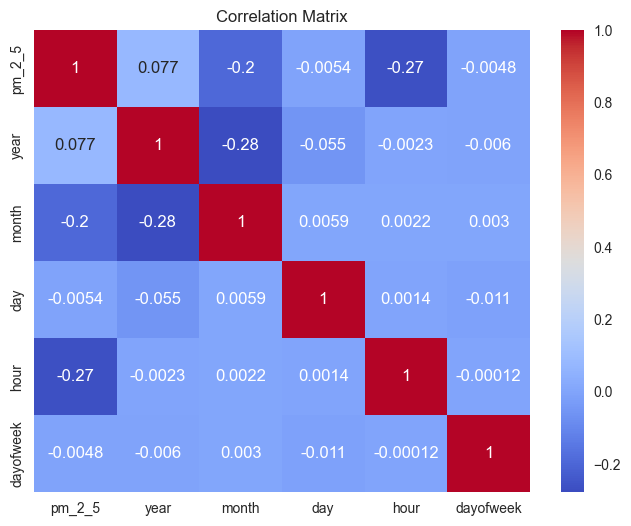

,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(24843, 6)"
4,Transformed data shape,"(24843, 6)"
5,Transformed train set shape,"(19874, 6)"
6,Transformed test set shape,"(4969, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,9.7253,151.6125,12.3077,0.1086,0.7870,1.4132,0.6820



Best model selected by PyCaret: LinearRegression(n_jobs=-1)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.4910,138.8286,11.7826,0.1042,0.7904,1.4186
1,9.7051,146.7556,12.1143,0.1090,0.7755,1.3316
2,9.7102,165.6906,12.8721,0.1120,0.7953,1.4971
3,9.7171,150.6937,12.2757,0.1123,0.7703,1.3678
4,10.0029,156.0941,12.4938,0.1057,0.8034,1.4511
Mean,9.7253,151.6125,12.3077,0.1086,0.7870,1.4132
Std,0.1629,9.0126,0.3653,0.0033,0.0123,0.0587


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Tuned Model: LinearRegression(n_jobs=-1)



การทำนายค่า PM2.5 สำหรับ 6 วันข้างหน้า (เวลา 07:00 น.)


KeyError: 'Label'

In [ ]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1) โหลดข้อมูล
# ----------------------------------------------------------------------------
df = pd.read_excel('./export-jsps014-1h.xlsx')

# ----------------------------------------------------------------------------
# 2) แปลงคอลัมน์ timestamp เป็น datetime
# ----------------------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# ----------------------------------------------------------------------------
# 3) ตรวจสอบ Missing Values เบื้องต้น และจัดการ
#    (ตัวอย่างนี้ใช้การ fill forward หาก timestamp เพี้ยนหรือเป็น NaT อาจต้องลบออก)
# ----------------------------------------------------------------------------
df = df.dropna(subset=['timestamp', 'pm_2_5'])  # ลบแถวที่ไม่มีค่า timestamp หรือ pm_2_5
df = df.fillna(method='ffill')  # เติมค่าว่างด้วยค่าก่อนหน้า (กรณีเวลาเรียงต่อกัน)

# ----------------------------------------------------------------------------
# 4) เก็บค่าวันที่สุดท้ายไว้สำหรับการทำนายอนาคต
# ----------------------------------------------------------------------------
last_date = df['timestamp'].max()

# ----------------------------------------------------------------------------
# 5) สร้างฟีเจอร์จากข้อมูลเวลา
#    สามารถสร้างเพิ่มได้ เช่น dayofweek (วันในสัปดาห์), quarter (ไตรมาส) ฯลฯ
# ----------------------------------------------------------------------------
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek  # วันในสัปดาห์ 0=Monday ... 6=Sunday

# ----------------------------------------------------------------------------
# 6) เลือกคอลัมน์ที่ต้องการใช้เป็นฟีเจอร์ และลบคอลัมน์ที่ไม่จำเป็น
#    หมายเหตุ: ถ้าคอลัมน์ temperature, humidity หรือ pm_2_5_sp มีประโยชน์
#    อาจพิจารณาเก็บไว้เป็นฟีเจอร์ได้เช่นกัน
# ----------------------------------------------------------------------------
columns_to_drop = [
    'timestamp', 'timezone', 'temperature', 'humidity',
    'pm_2_5_sp', 'Unnamed: 0'
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
df = df.reset_index(drop=True)

print("\nTraining data columns:\n", df.columns)

# ----------------------------------------------------------------------------
# 7) สำรวจความสัมพันธ์เบื้องต้นด้วย Heatmap (Optional)
# ----------------------------------------------------------------------------
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# ----------------------------------------------------------------------------
# 8) ตั้งค่า PyCaret
#    - transformation=True เพื่อปรับสเกลข้อมูล
#    - feature_interaction=True เพื่อสร้างฟีเจอร์เชิงอนุพันธ์
#    - polynomial_features=True เพื่อสร้างฟีเจอร์กำลัง 2 หรือ 3
#      (กำหนด polynomial_degree=2)
#    - fold=5 เพื่อทำ cross-validation 5 folds
# ----------------------------------------------------------------------------
experiment = setup(
    data=df,
    target='pm_2_5',
    train_size=0.8,
    session_id=42,
    fold=5,
    numeric_features=['year', 'month', 'day', 'hour', 'dayofweek'],
    transformation=True,
    polynomial_features=True,
    polynomial_degree=2,
    gpu=True
)

# ----------------------------------------------------------------------------
# 9) เปรียบเทียบโมเดลหลายตัว (ตัวอย่าง: LR, RF, LightGBM, XGBoost)
#    - หากต้องการดูโมเดลทั้งหมดสามารถละ include=[] ได้
# ----------------------------------------------------------------------------
best_model = compare_models()

# แสดงชื่อโมเดลที่ดีที่สุด
print(f"\nBest model selected by PyCaret: {best_model}")

# ----------------------------------------------------------------------------
# 10) ปรับจูนโมเดลที่ดีที่สุด (Hyperparameter Tuning) (ถ้าต้องการ)
# ----------------------------------------------------------------------------
tuned_model = tune_model(best_model, optimize='RMSE')
print(f"\nTuned Model: {tuned_model}")

# ----------------------------------------------------------------------------
# 11) สร้างโมเดล Final เพื่อนำไปใช้งานจริง
# ----------------------------------------------------------------------------
final_model = finalize_model(tuned_model)

# ----------------------------------------------------------------------------
# 12) สร้างข้อมูลอนาคตสำหรับทำนาย (ตัวอย่าง: 6 วันข้างหน้า, freq='D')
#     กำหนดเวลาเป็น 07:00 น. และ dayofweek ตามวันที่จริง
# ----------------------------------------------------------------------------
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=6, freq='D')

future_data = pd.DataFrame()
future_data['year'] = future_dates.year
future_data['month'] = future_dates.month
future_data['day'] = future_dates.day
future_data['hour'] = 7
future_data['dayofweek'] = future_dates.dayofweek  # วันในสัปดาห์

# ----------------------------------------------------------------------------
# 13) ทำนายค่า PM2.5
# ----------------------------------------------------------------------------
predictions = predict_model(final_model, data=future_data)

In [ ]:
import pandas as pd
from pycaret.regression import setup, compare_models, finalize_model, predict_model, tune_model
from datetime import timedelta
import logging


def load_and_preprocess_data(file_path):
    """
    โหลดข้อมูลจากไฟล์ Excel และเตรียมข้อมูลสำหรับการเทรนโมเดล
    """
    # โหลดข้อมูล
    df = pd.read_excel(file_path)

    # แปลงคอลัมน์ timestamp เป็น datetime และเก็บค่าวันล่าสุดไว้
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    last_date = df['timestamp'].max()

    # สร้างฟีเจอร์จากข้อมูลเวลา
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour

    # ลบคอลัมน์ที่ไม่จำเป็น
    columns_to_drop = ['timestamp','timezone', 'temperature', 'humidity', 'pm_2_5_sp', 'Unnamed: 0']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # รีเซ็ต index
    df.reset_index(drop=True, inplace=True)

    return df, last_date

def train_and_test_model(df):

    # ตั้งค่า PyCaret โดยกำหนด train_size=0. (20% จะถูก set aside เป็น hold-out test set)
    exp = setup(
    data=df,
    target='pm_2_5',
    train_size=0.8,
    session_id=42,
    fold=10,
    preprocess=True,
    use_gpu=False,
    verbose=False,
    n_jobs=1,  
    numeric_features=['year', 'month', 'day', 'hour']
)


    # เปรียบเทียบและเลือกโมเดลเฉพาะ Linear Regression
    best_model = compare_models(include=['rf', 'lr', 'lightgbm'])


    tuned_model = tune_model(best_model, optimize='R2', n_iter=10)
    holdout_data = predict_model(tuned_model)

    # เทสโมเดลบน hold-out set (ถ้าไม่ได้ส่ง data เข้าไปใน predict_model จะใช้ hold-out set ที่ถูกตั้งค่าไว้ใน setup))
    #holdout_data = predict_model(best_model)


    # คำนวณค่า R² score โดยเทียบระหว่างค่าจริงและค่าที่ทำนายได้
    r2 = r2_score(holdout_data['pm_2_5'], holdout_data['prediction_label'])
    print("Model Accuracy (R² Score): {:.2f}%".format(r2 * 100))

    return best_model

def finalize_and_predict(best_model, last_date):
    """
    ทำการ finalize โมเดล (เทรนใหม่บนข้อมูลทั้งหมด) และทำนายค่า PM2.5 ในอนาคต
    """
    # Finalize โมเดลโดยเทรนบนข้อมูลทั้งหมด (hold-out set จะถูกรวมเข้าด้วย)
    final_model = finalize_model(best_model)

    # สร้าง DataFrame สำหรับการทำนายใน 6 วันข้างหน้า (ตั้งเวลาเป็น 07:00 น.)
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=6, freq='D')
    future_data = pd.DataFrame({
        'year': future_dates.year,
        'month': future_dates.month,
        'day': future_dates.day,
        'hour': 7
    })

    # ทำนายค่า PM2.5 สำหรับข้อมูลในอนาคต
    predictions = predict_model(final_model, data=future_data)

    print("\nการทำนายค่า PM2.5 สำหรับ 6 วันข้างหน้า:")
    for date, pred in zip(future_dates, predictions['prediction_label']):
        print(f"วันที่ {date.strftime('%Y-%m-%d')} เวลา 07:00 น.: {pred:.2f} µg/m³")

    # บันทึกผลการทำนายในไฟล์ Excel
    predictions.to_excel('pm25_predictions.xlsx', index=False)
    print("\nบันทึกผลการทำนายลงในไฟล์ 'pm25_predictions.xlsx' เรียบร้อยแล้ว")

def main():
    logging.basicConfig(level=logging.INFO)
    input_file = './export-jsps014-1h.xlsx'

    # โหลดและเตรียมข้อมูล
    df, last_date = load_and_preprocess_data(input_file)
    logging.info("Training data columns: %s", df.columns.tolist())

    # เทรนและเทสโมเดล พร้อมแสดง R² Score เป็นเปอร์เซ็นต์
    best_model = train_and_test_model(df)

    # Finalize โมเดลและทำนายค่าในอนาคต
    finalize_and_predict(best_model, last_date)

if __name__ == '__main__':
    main()


INFO:root:Training data columns: ['pm_2_5', 'year', 'month', 'day', 'hour']


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,4.4904,44.7778,6.6728,0.7375,0.4154,0.4783,2.5110
lightgbm,Light Gradient Boosting Machine,6.5214,75.0848,8.6485,0.5595,0.5718,0.8356,0.0970
lr,Linear Regression,9.7228,151.5060,12.2971,0.1094,0.7868,1.4129,0.0130


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:16:20
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
